# Forecasting CNBS
Lindsay Fitzpatrick
ljob@umich.edu
08/19/2024
Updated: 02/20/2025

This script:
1. Opens the CSV files with the CFS forecasts. 
2. Runs the forecast through the trained Gaussian Process model. 
3. Produces an ensemble of RNBS forecasts for each of the Great Lakes.
4. Saves the forecast to a CSV file.
5. Creates a timeseries plot and saves it as a PNG file. 

This script needs the following files:

- input
    - GL_mask.nc
    - GP_trained_model.joblib
    - x_scaler.joblib
    - y_scaler.joblib
- data
    - CFS_EVAP_forecasts_Avgs_MM.csv
    - CFS_PCP_forecasts_Avgs_MM.csv
    - CFS_TMP_forecasts_Avgs_K.csv

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import joblib
import calendar

User Input

In [6]:
# Directory to input data
#dir = '/Users/fitzpatrick/Desktop/cnbs-predictor/data/input/'
dir = '/Users/fitzpatrick/Desktop/Data/'

# Read in the CSVs
tmp_csv = dir + 'CFS_TMP_forecasts_Avgs_K.csv'
evap_csv = dir + 'CFS_EVAP_forecasts_Avgs_MM.csv'
pcp_csv = dir + 'CFS_PCP_forecasts_Avgs_MM.csv'

# Open the trained model(s)
GP_model = joblib.load('GP_trained_model.joblib')

# Define Functions

Determine the mean/median, min, and max RNBS values for each month from the ensemble members.

In [7]:
def calculate_median_confidence(df,lake):
    median = df.groupby(['year', 'month'])[lake].median().reset_index()
    #min = df.groupby(['year', 'month'])[lake].min().reset_index()
    #max = df.groupby(['year', 'month'])[lake].max().reset_index()

    # Calculate the 2.5th and 97.5th percentiles for the confidence band
    lower_bound = df.groupby(['year', 'month'])[lake].quantile(0.025).reset_index()
    upper_bound = df.groupby(['year', 'month'])[lake].quantile(0.975).reset_index()

    return median, lower_bound, upper_bound

Calculate the number of seconds in a month based on the month and the year. This is used to calculate units between cms and mm.

In [8]:
def seconds_in_month(year, month):
    # Number of days in the month
    num_days = calendar.monthrange(year, month)[1]
    # Convert days to seconds
    return num_days * 24 * 60 * 60

Convert a dataframe in [cms] to [mm].

In [9]:
def convert_cms_to_mm(df_cms):

    # Create a copy of the dataframe so we aren't altering the df_cms
    df_mm = df_cms.copy()

    sa_sup = 82097*1000000
    sa_mih = (57753 + 5956)*1000000
    sa_eri = 25655*1000000
    sa_ont = 19009*1000000
    
    # Calculate the number of seconds for each month
    df_mm['seconds'] = df_mm.apply(lambda row: seconds_in_month(int(row['year']), int(row['month'])), axis=1)

    # value_cms / surface_area * seconds_in_a_month = m * 1000 = mm
    for column in df_mm.columns:
        if column.startswith("eri"):
            df_mm[column] = df_mm[column] / sa_eri * df_mm['seconds'] * 1000
        elif column.startswith("sup"):
            df_mm[column] = df_mm[column] / sa_sup * df_mm['seconds'] * 1000
        elif column.startswith("mih"):
            df_mm[column] = df_mm[column] / sa_mih * df_mm['seconds'] * 1000
        elif column.startswith("ont"):
            df_mm[column] = df_mm[column] / sa_ont * df_mm['seconds'] * 1000

    # Deleting column 'seconds'
    df_mm.drop('seconds', axis=1)

    return df_mm

In [10]:
def convert_mm_to_cms(df_mm):

    # Create a copy of the dataframe so we aren't altering the df_cms
    df_cms = df_mm.copy()

    sa_sup = 82097*1000000
    sa_mih = (57753 + 5956)*1000000
    sa_eri = 25655*1000000
    sa_ont = 19009*1000000
    
    # Calculate the number of seconds for each month
    df_cms['seconds'] = df_cms.apply(lambda row: seconds_in_month(int(row['year']), int(row['month'])), axis=1)

    # value_mm / 1000 [to convert to m] * surface_area / seconds_in_a_month
    for column in df_mm.columns:
        if column.startswith("eri"):
            df_cms[column] = ((df_cms[column] / 1000) * sa_eri) / df_cms['seconds']
        elif column.startswith("sup"):
            df_cms[column] = ((df_cms[column] / 1000) * sa_sup) / df_cms['seconds']
        elif column.startswith("mih"):
            df_cms[column] = ((df_cms[column] / 1000) * sa_mih) / df_cms['seconds']
        elif column.startswith("ont"):
            df_cms[column] = ((df_cms[column] / 1000) * sa_ont) / df_cms['seconds']

    # Deleting column 'seconds'
    df_cms.drop('seconds', axis=1)

    return df_cms

Function to create a 4 plot figure displaying the RNBS forecast for each lake going out 9 months.

In [12]:
def plot_cnbs_forecast(x_values, data_dict):
    """
    Plots RNBS forecasts for different lakes.

    Parameters:
    - x_values: array-like, the x-axis values (e.g., months)
    - data_dict: dictionary containing data for each lake. The keys are lake names, and the values are tuples containing
                 (mean, min, max) for that lake.

    The dictionary should be formatted as:
    {
        'Lake Superior': (mean_su, min_su, max_su),
        'Lake Erie': (mean_er, min_er, max_er),
        'Lake Ontario': (mean_on, min_on, max_on),
        'Lake Mich-Huron': (mean_mh, min_mh, max_mh)
    }
    """
    # Create a 4x1 grid of subplots
    fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
    
    # Titles for the subplots
    titles = [
        'Lake Superior 9-month CNBS Forecast',
        'Lake Erie 9-month CNBS Forecast',
        'Lake Ontario 9-month CNBS Forecast',
        'Lake Mich-Huron 9-month CNBS Forecast'
    ]
    
    for i, (mean, min_val, max_val) in enumerate(data_dict.values()):
        axs[i].plot(x_values, mean, color='red', linestyle='-', linewidth=1.5, label='Median')
        axs[i].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
        axs[i].fill_between(x_values, min_val, max_val, color='gray', alpha=0.2, label='95% Confidence')
        axs[i].set_ylabel('CNBS [mm]')
        axs[i].set_title(titles[i])
        axs[i].set_xlim(0, len(mean) - 1)
        axs[i].set_ylim(min_val.min() - 10, max_val.max() + 10)
        axs[i].grid(True, linestyle='--', alpha=0.6)

    # Place the legend on the top plot
    axs[0].legend(loc='upper right')
    # Set x-tick labels for the last subplot
    axs[-1].set_xticklabels([calendar.month_abbr[month] for month in median_su['month'][:len(mean)]])
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig(dir+f'CNBS_forecasts.png', bbox_inches='tight')
    plt.show()

# Begin Script

Read in the precip, evap, and air temp forecasts from the CFS forecast. We add the totals for Mich and 
Huron together with the exception of air temp where we take the average of the two lakes. We put them all
into a new dataframe 'X' which will be our features to run through the models.

In [13]:
## Read in PCP data from CFSR [mm]
pcp_data = pd.read_csv(pcp_csv,sep=',')

## Read in EVAP data from CFSR [mm]
evap_data = pd.read_csv(evap_csv,sep=',')

## Read in TMP data from CFSR [K]
tmp_data = pd.read_csv(tmp_csv,sep=',')

In [14]:
X = pd.DataFrame({
    'sup_pcp_w': pcp_data['sup_lake'],
    'eri_pcp_w': pcp_data['eri_lake'],
    'ont_pcp_w': pcp_data['ont_lake'],
    'mih_pcp_w': pcp_data['mih_lake'],
    'sup_pcp_l': pcp_data['sup_land'],
    'eri_pcp_l': pcp_data['eri_land'],
    'ont_pcp_l': pcp_data['ont_land'],
    'mih_pcp_l': pcp_data['mih_land'],
    'sup_evap_w': evap_data['sup_lake'],
    'eri_evap_w': evap_data['eri_lake'],
    'ont_evap_w': evap_data['ont_lake'],
    'mih_evap_w': evap_data['mih_lake'],
    'sup_evap_l': evap_data['sup_land'],
    'eri_evap_l': evap_data['eri_land'],
    'ont_evap_l': evap_data['ont_land'],
    'mih_evap_l': evap_data['mih_land'],
    'sup_tmp_w': tmp_data['sup_lake'],
    'eri_tmp_w': tmp_data['eri_lake'],
    'ont_tmp_w': tmp_data['ont_lake'],
    'mih_tmp_w': tmp_data['mih_lake'],
    'sup_tmp_l': tmp_data['sup_land'],
    'eri_tmp_l': tmp_data['eri_land'],
    'ont_tmp_l': tmp_data['ont_land'],
    'mih_tmp_l': tmp_data['mih_land']
})

Standardize the data

In [15]:
# Standardize the data
x_scaler = joblib.load('x_scaler.joblib')
y_scaler = joblib.load('y_scaler.joblib')
X_scaled = x_scaler.transform(X)

Run the scaled data through the trained GP model. Put the results into a new dataframe. Add the month
as a column in the dataframe. Then save the RNBS forecast to a CSV. 

In [16]:
# Predict CNBS using GP
y_pred_scaled = GP_model.predict(X_scaled)

y_pred = y_scaler.inverse_transform(y_pred_scaled) # unscale the predictions

In [17]:
# Convert to dataframe and add column names
df_y_pred = pd.DataFrame(y_pred, columns=['sup_evap', 
                                          'sup_pcp',
                                          'sup_rnoff',
                                          'eri_evap',
                                          'eri_pcp',
                                          'eri_rnoff',
                                          'ont_evap',
                                          'ont_pcp',
                                          'ont_rnoff',
                                          'mih_evap',
                                          'mih_pcp',
                                          'mih_rnoff'])

Add the forecast month and year as columns in the new dataframe along side the CNBS forecast.

In [18]:
# Add back the columns with cfs_run, forecast_year, forecast_month
df_y_pred['cfs_run'] = pcp_data['cfs_run'].astype(int)
df_y_pred['year'] = pcp_data['forecast_year'].astype(int)
df_y_pred['month'] = pcp_data['forecast_month'].astype(int)

# Reorder the columns to move 'year' and 'month' to the left
cols = ['cfs_run','year', 'month'] + [col for col in df_y_pred.columns if col not in ['cfs_run','year', 'month']]
df_y_pred = df_y_pred[cols]

In [19]:
print(df_y_pred)

          cfs_run  year  month   sup_evap    sup_pcp  sup_rnoff    eri_evap  \
0      2024010100  2024      1  68.255257  27.865835  28.042089   37.476740   
1      2024010100  2024      2  66.963064  24.650756  27.825407   25.005297   
2      2024010100  2024      3  73.169683  40.439081  34.728045   49.595654   
3      2024010100  2024      4  49.521633  29.671396  51.213260   71.318207   
4      2024010100  2024      5  22.227339  90.953675  56.505806  111.969488   
...           ...   ...    ...        ...        ...        ...         ...   
16856  2025021918  2025      7  24.188639  97.244904  44.903424  111.619826   
16857  2025021918  2025      8  33.034324  64.819222  35.122647  119.198953   
16858  2025021918  2025      9  56.707276  78.019463  47.626460  120.078887   
16859  2025021918  2025     10  63.504506  68.832120  48.878387   93.120045   
16860  2025021918  2025     11  70.246429  92.292035  44.259553   74.502571   

          eri_pcp   eri_rnoff   ont_evap     ont_pc

In [20]:
df_y_pred['sup_cnbs'] = df_y_pred['sup_pcp'] + df_y_pred['sup_rnoff'] - df_y_pred['sup_evap']
df_y_pred['eri_cnbs'] = df_y_pred['eri_pcp'] + df_y_pred['eri_rnoff'] - df_y_pred['eri_evap']
df_y_pred['ont_cnbs'] = df_y_pred['ont_pcp'] + df_y_pred['ont_rnoff'] - df_y_pred['ont_evap']
df_y_pred['mih_cnbs'] = df_y_pred['mih_pcp'] + df_y_pred['mih_rnoff'] - df_y_pred['mih_evap']

In [21]:
df_y_pred.to_csv(dir+'CNBS_forecasts.csv',sep=',',index=False)

Before plotting, we can remove any forecasts that are from previous months that have passed and only look at the future months forecasts.

If the current day is later than the 26th day of the month, the first forecast month needs to be the next month. This was a request by USACE.

In [22]:
current_day = datetime.now().day
current_month = datetime.now().month
current_year = datetime.now().year

# Determine filtering condition based on the day of the month
if current_day >= 26:
    # Remove this month and all previous months
    filtered_y_pred = df_y_pred[
        (df_y_pred['year'] > current_year) |
        (df_y_pred['year'] == current_year) & (df_y_pred['month'] > current_month)
    ]
    print(f"First month forecast: {current_month+1}")
else:
    # Keep this month
    filtered_y_pred = df_y_pred[
        (df_y_pred['year'] > current_year) |
        ((df_y_pred['year'] == current_year) & (df_y_pred['month'] >= current_month))
    ]
    print(f"First month forecast: {current_month}")

First month forecast: 2


Save the CNBS forecast to a CSV file.

In [23]:
filtered_y_pred.to_csv(dir+'CNBS_forecasts_mm.csv',sep=',',index=False)

Convert CNBS from [mm] to [cms] and save to a new CSV file.

In [24]:
df_y_cms = convert_mm_to_cms(filtered_y_pred)

In [25]:
df_y_cms.to_csv(dir+'CNBS_forecasts_cms.csv',sep=',',index=False)

Calculate the median of the ensemble forecasts for each month as well as the 95% confidence band.

In [26]:
df_y = filtered_y_pred

In [27]:
median_su, min_su, max_su = calculate_median_confidence(df_y,'sup_cnbs')
median_er, min_er, max_er = calculate_median_confidence(df_y,'eri_cnbs')
median_on, min_on, max_on = calculate_median_confidence(df_y,'ont_cnbs')
median_mh, min_mh, max_mh = calculate_median_confidence(df_y,'mih_cnbs')

Plot the forecast.

/var/folders/vk/sq308v2d4b97_kz7sj68_3x00000gn/T/ipykernel_30424/4153923874.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[-1].set_xticklabels([calendar.month_abbr[month] for month in median_su['month'][:len(mean)]])


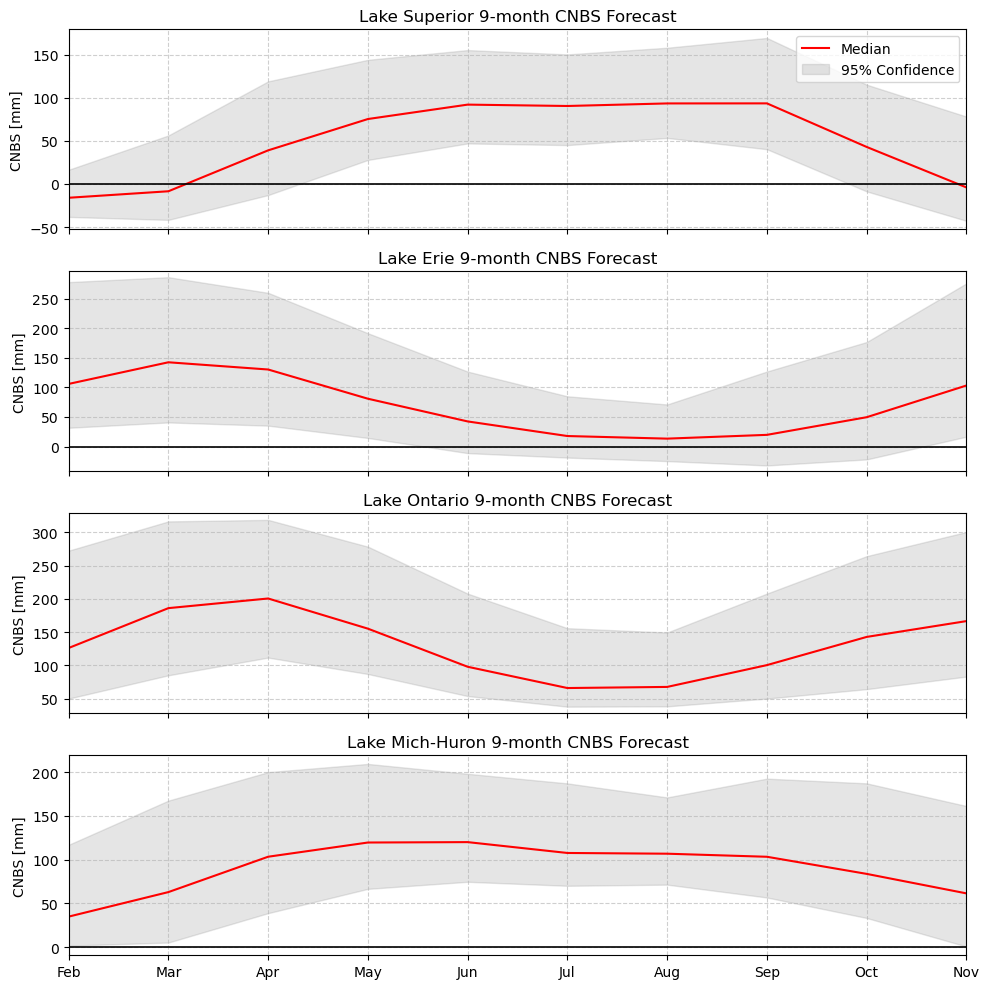

In [29]:
x_values = np.arange(len(median_su['sup_cnbs']))  # x-axis values
data_dict = {
    'Lake Superior': (median_su['sup_cnbs'], min_su['sup_cnbs'], max_su['sup_cnbs']),
    'Lake Erie': (median_er['eri_cnbs'], min_er['eri_cnbs'], max_er['eri_cnbs']),
    'Lake Ontario': (median_on['ont_cnbs'], min_on['ont_cnbs'], max_on['ont_cnbs']),
    'Lake Mich-Huron': (median_mh['mih_cnbs'], min_mh['mih_cnbs'], max_mh['mih_cnbs'])
}

plot_cnbs_forecast(x_values, data_dict)